# Level 3 Advanced Notebook

Classification models with tuning and NLP sentiment analysis.

Generated on 2025-09-29 19:07:11 UTC.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path
import re

# your Windows file paths
iris_path  = Path(r"C:\Users\mfgdiags1\Downloads\1) iris.csv")
senti_path = Path(r"C:\Users\mfgdiags1\Downloads\3) Sentiment dataset.csv")

# load data
iris  = pd.read_csv(iris_path, encoding="utf-8")
senti = pd.read_csv(senti_path, encoding="utf-8")
print("Loaded iris rows", iris.shape[0], "cols", iris.shape[1])
print("Loaded sentiment rows", senti.shape[0], "cols", senti.shape[1])



Loaded iris rows 150 cols 5
Loaded sentiment rows 732 cols 15


# Task 1 Predictive Modeling Classification on Iris

In [4]:
# Expect iris to have numeric features and a target species/class column
y_col = None
for c in iris.columns:
    if c.lower() in ["species", "class", "target", "label"]:
        y_col = c
        break
if y_col is None:
    y_col = iris.columns[-1]  # fallback

X = iris.drop(columns=[y_col])
y = iris[y_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if y.nunique() > 1 else None
)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features)
])

# Models
models = {
    "logistic": LogisticRegression(max_iter=1000),
    "tree": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(random_state=42)
}

# Parameter grids, using "model__" prefix since model sits inside the pipeline
params = {
    "logistic": {"model__C": [0.1, 1.0, 10.0]},
    "tree": {"model__max_depth": [None, 3, 5, 8]},
    "rf": {"model__n_estimators": [100, 200], "model__max_depth": [None, 5, 10]}
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("pre", pre),
        ("model", model)
    ])
    gs = GridSearchCV(pipe, params[name], cv=3, n_jobs=-1)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)

    results[name] = {
        "best_params": gs.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "report": classification_report(y_test, y_pred, zero_division=0)
    }

# Print summary
for k, v in results.items():
    print(f"\nModel: {k}")
    print("Best params:", v["best_params"])
    print("Accuracy:", v["accuracy"])
    print("Precision:", v["precision"])
    print("Recall:", v["recall"])
    print("F1:", v["f1"])
    print("\nReport:\n", v["report"])



Model: logistic
Best params: {'model__C': 10.0}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Model: tree
Best params: {'model__max_depth': 3}
Accuracy: 0.9666666666666667
Precision: 0.9696969696969696
Recall: 0.9666666666666667
F1: 0.9665831244778613

Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg    

# Task 3 NLP Sentiment Analysis

Note. Some classes are very small. Using a non stratified split to avoid errors.
Accuracy: 0.11564625850340136
Precision: 0.021788622999276752
Recall: 0.11564625850340136
F1: 0.033144128514481716

Report
                         precision    recall  f1-score   support

         Acceptance          0.00      0.00      0.00         2
      Acceptance             0.00      0.00      0.00         0
           Admiration        0.00      0.00      0.00         1
        Admiration           0.00      0.00      0.00         1
         Affection           0.00      0.00      0.00         1
      Ambivalence            0.00      0.00      0.00         1
         Anger               0.00      0.00      0.00         1
        Anticipation         0.00      0.00      0.00         1
        Arousal              0.00      0.00      0.00         3
                  Awe        0.00      0.00      0.00         1
         Awe                 0.00      0.00      0.00         1
                  Bad     

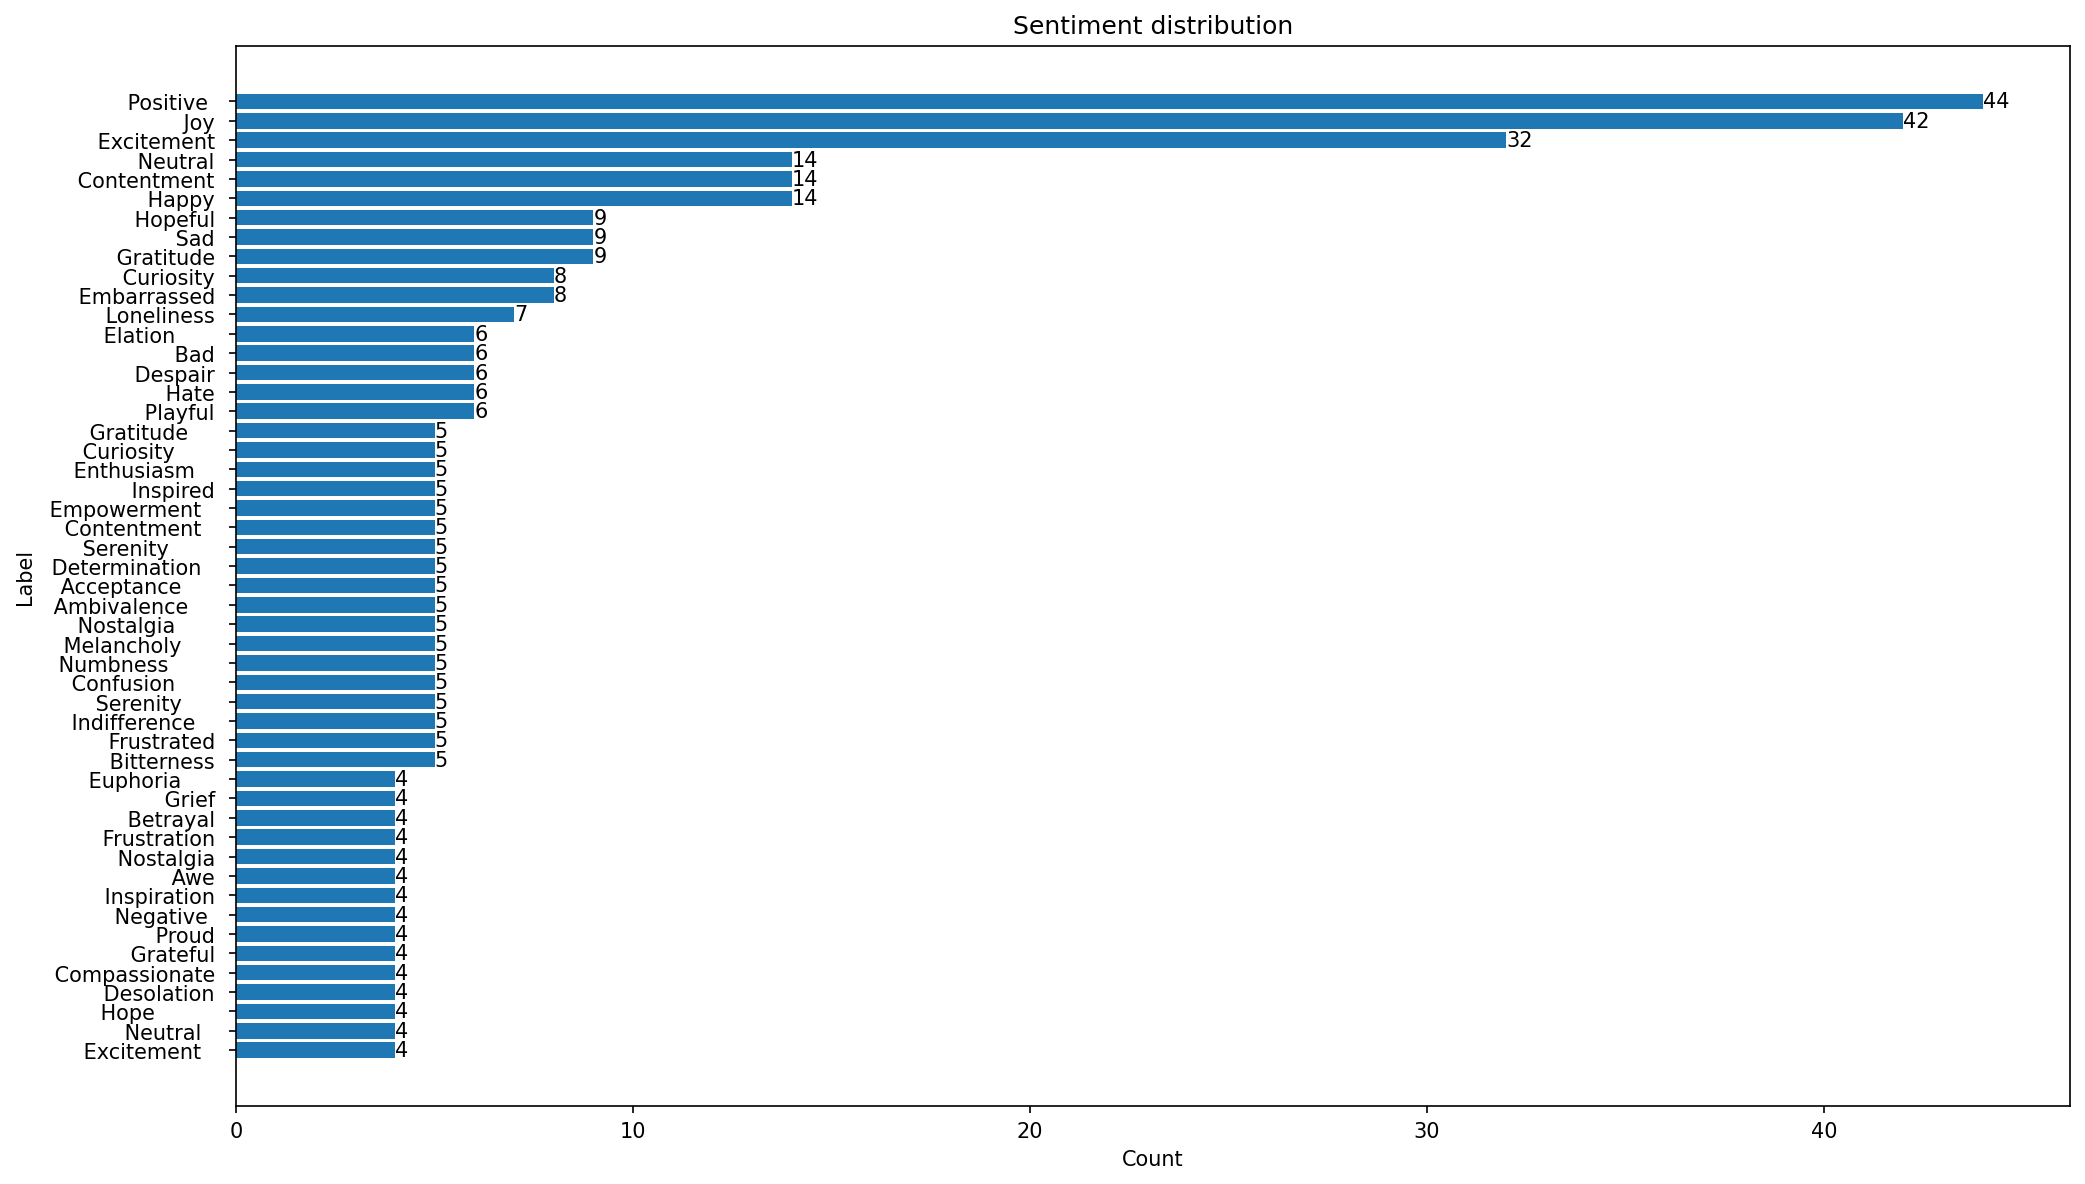

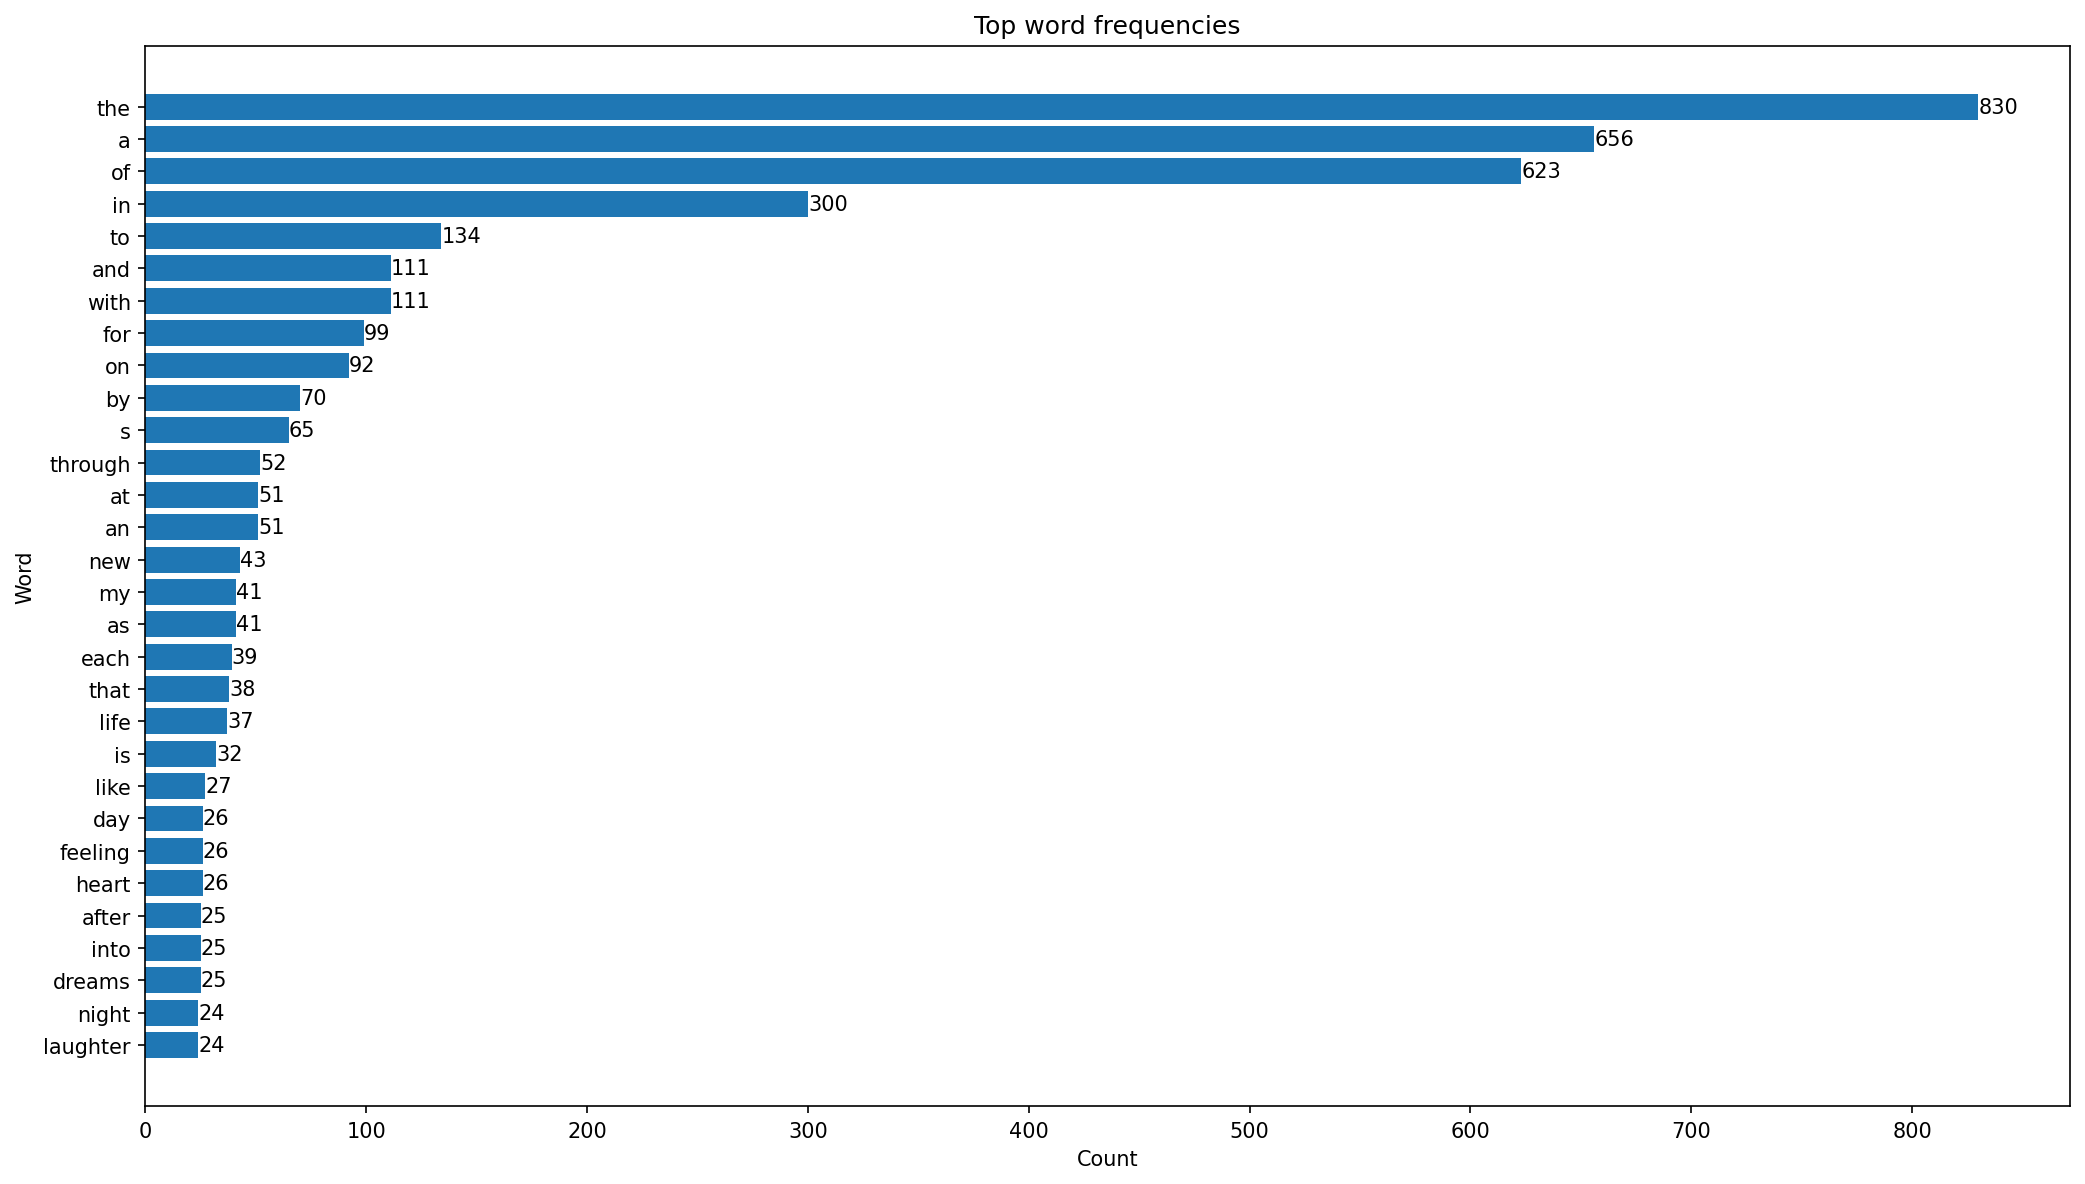

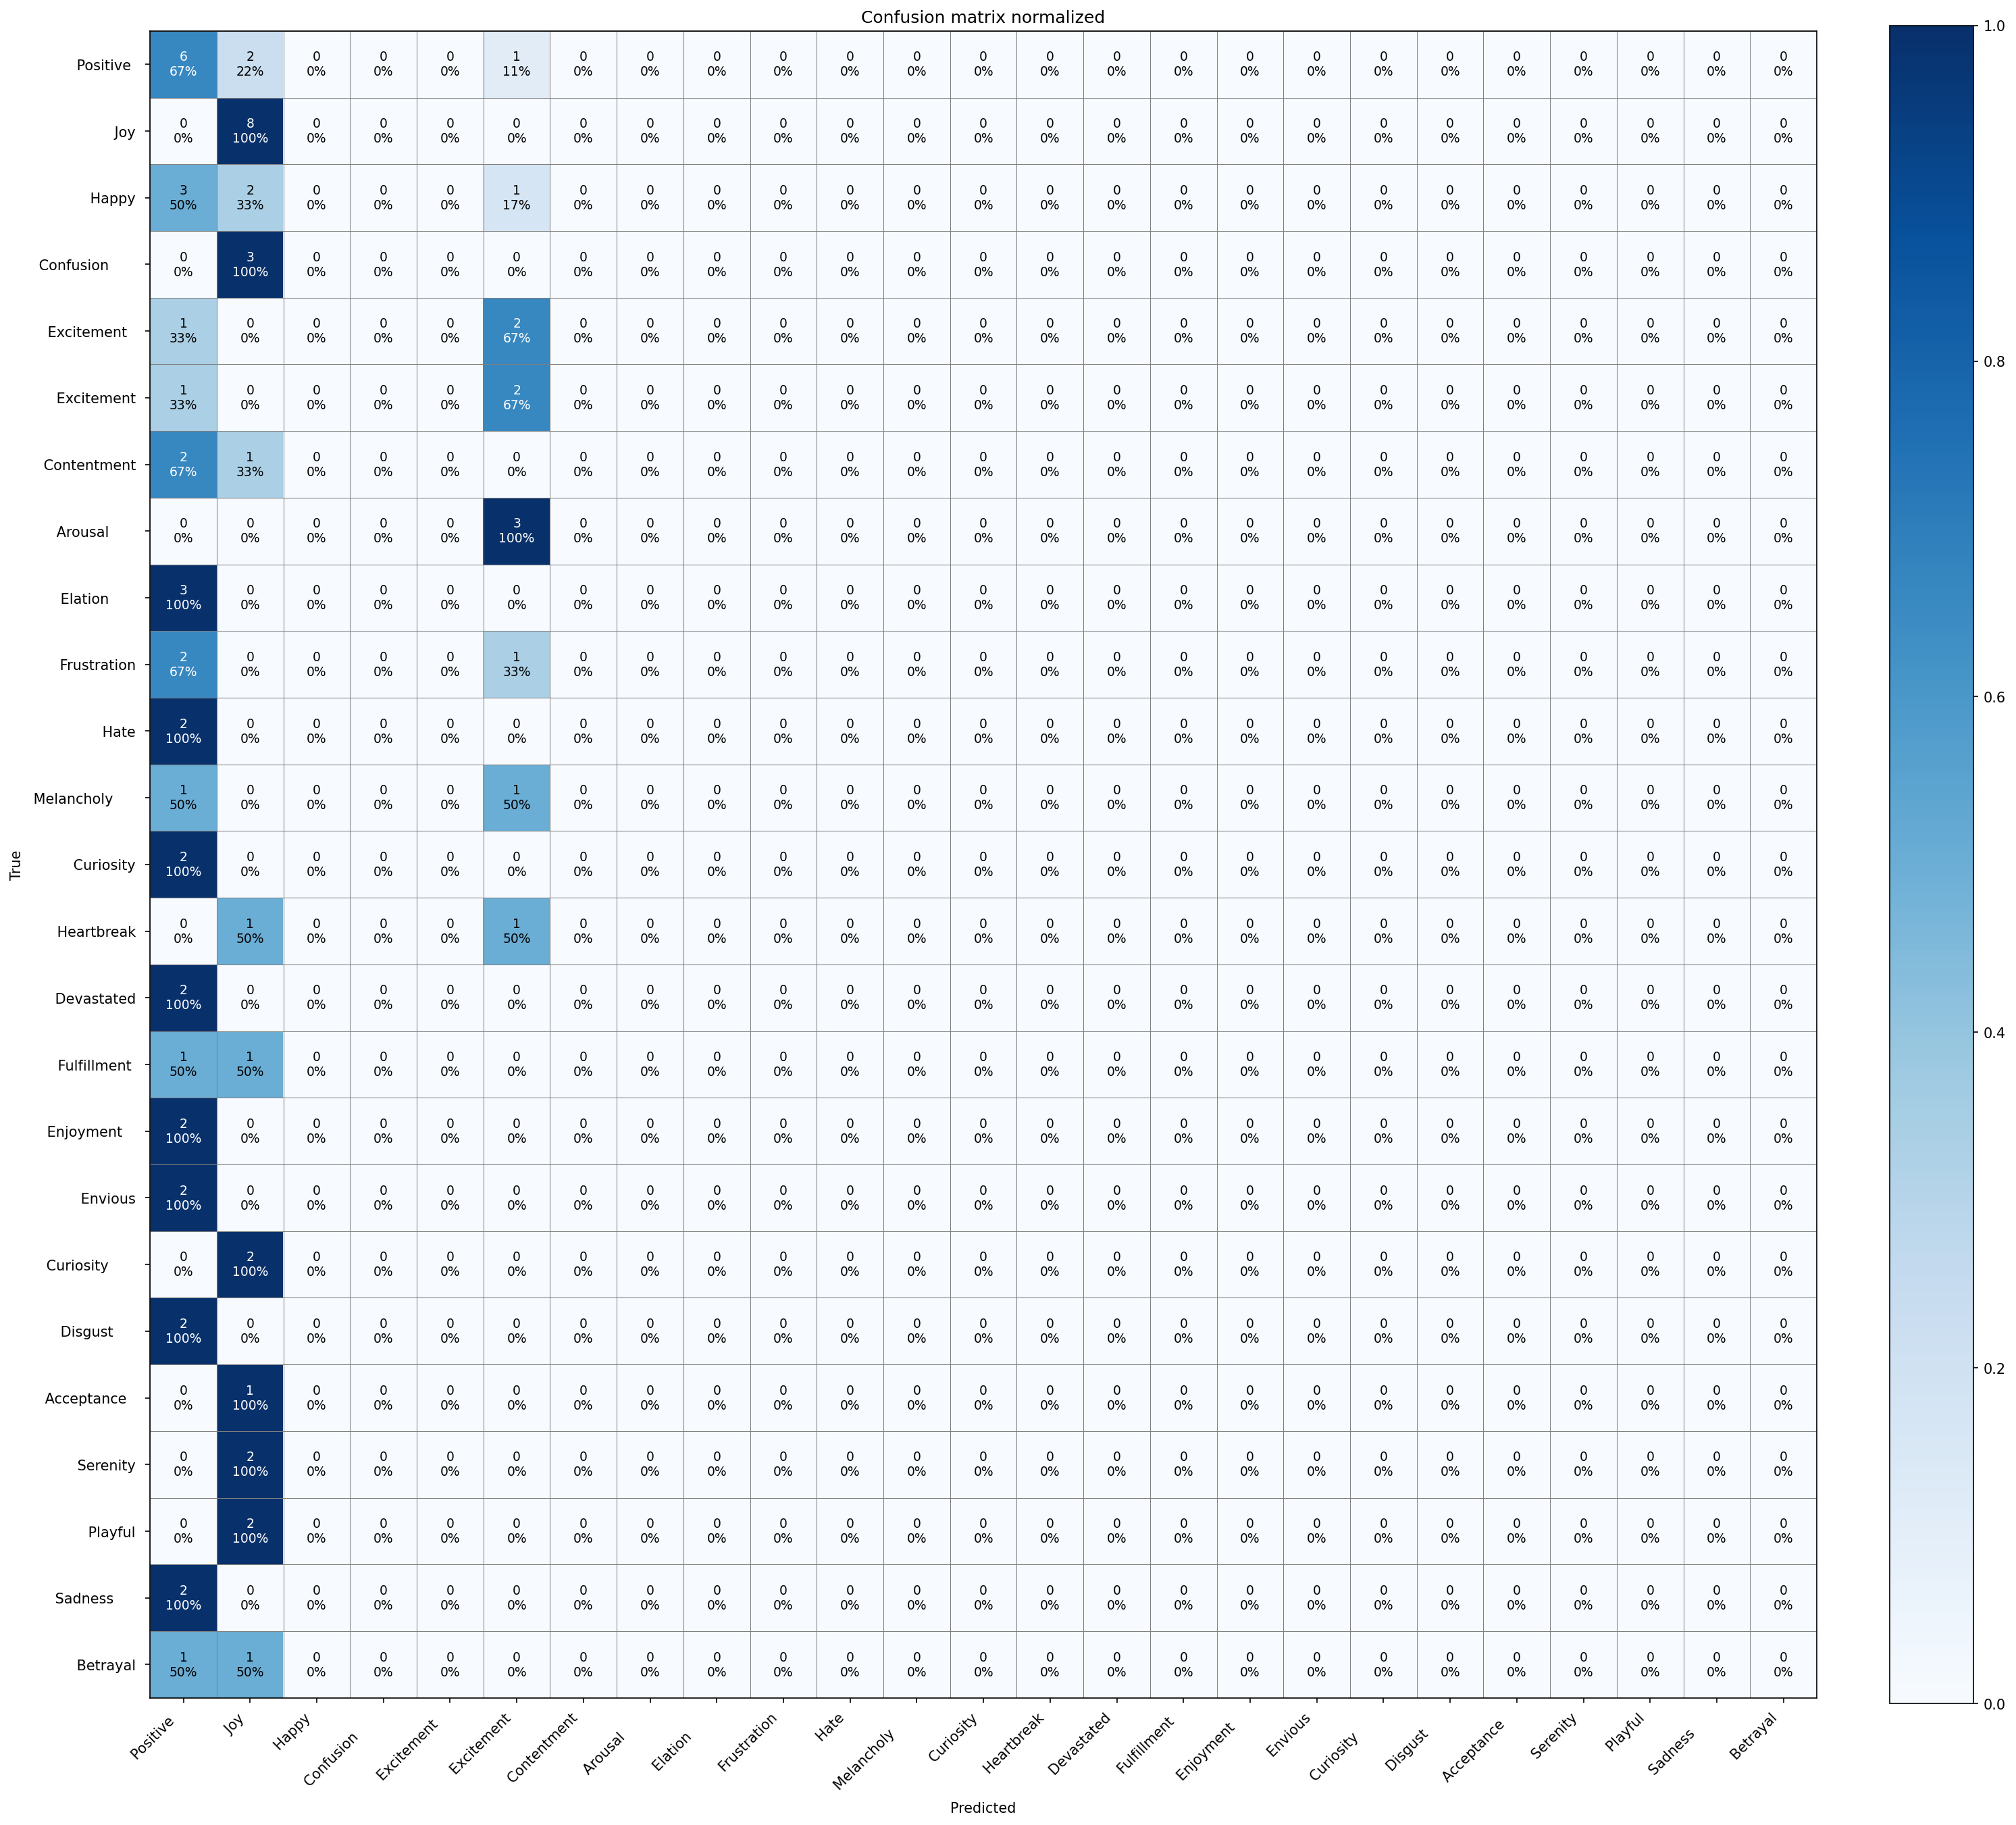

In [8]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# big, crisp figures
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["figure.dpi"] = 150

def plot_value_counts(series, title, top_n=50, horizontal=True, annotate=True):
    vc = series.value_counts()
    if top_n is not None and len(vc) > top_n:
        vc = vc.head(top_n)
    plt.figure()
    if horizontal:
        bars = plt.barh(vc.index.astype(str)[::-1], vc.values[::-1])
        if annotate:
            for bar, val in zip(bars, vc.values[::-1]):
                x = bar.get_width()
                y = bar.get_y() + bar.get_height() / 2
                plt.text(x, y, str(val), va="center", ha="left", fontsize=10)
        plt.xlabel("Count")
        plt.ylabel("Label")
    else:
        bars = plt.bar(vc.index.astype(str), vc.values)
        if annotate:
            for bar, val in zip(bars, vc.values):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                plt.text(x, y, str(val), va="bottom", ha="center", fontsize=10)
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_pretty(y_true, y_pred, labels=None, normalize=True, top_n=None):
    if labels is None:
        labels = sorted(set(list(y_true) + list(y_pred)))
    support = np.array([(np.array(y_true) == l).sum() for l in labels])
    order = np.argsort(-support)
    if top_n is not None and top_n < len(labels):
        order = order[:top_n]
    labels_ord = [labels[i] for i in order]

    cm = confusion_matrix(y_true, y_pred, labels=labels_ord)

    if normalize:
        with np.errstate(divide="ignore", invalid="ignore"):
            cm_norm = cm / cm.sum(axis=1, keepdims=True)
            cm_norm = np.nan_to_num(cm_norm)
        matrix_to_show = cm_norm
        title_extra = " normalized"
    else:
        matrix_to_show = cm
        title_extra = ""

    n = len(labels_ord)
    size = min(20, 0.8 * n + 6)
    fig, ax = plt.subplots(figsize=(size, size), dpi=150)

    im = ax.imshow(matrix_to_show, cmap="Blues")
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title("Confusion matrix" + title_extra)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels_ord, rotation=45, ha="right")
    ax.set_yticklabels(labels_ord)
    ax.set_ylim(n - 0.5, -0.5)

    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="gray", linewidth=0.5)
    ax.tick_params(which="minor", length=0)

    thresh = matrix_to_show.max() / 2.0
    for i in range(n):
        for j in range(n):
            if normalize:
                txt = f"{cm[i, j]}\n{matrix_to_show[i, j]*100:.0f}%"
            else:
                txt = str(matrix_to_show[i, j])
            ax.text(j, i, txt,
                    ha="center", va="center", fontsize=9,
                    color="white" if matrix_to_show[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# find text and label columns
text_col = None
label_col = None
for c in senti.columns:
    cl = c.lower()
    if cl in ["text", "review", "message", "comment", "tweet"]:
        text_col = c
    if cl in ["label", "sentiment", "target", "class"]:
        label_col = c
if text_col is None:
    cand = senti.select_dtypes(include=["object"]).columns
    text_col = cand[0] if len(cand) else senti.columns[0]
if label_col is None:
    label_col = senti.columns[-1]

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def safe_split(X, y, test_size=0.2, random_state=42):
    counts = y.value_counts()
    min_count = counts.min()
    if min_count < 2 or int(min_count * test_size) < 1:
        print("Note. Some classes are very small. Using a non stratified split to avoid errors.")
        return train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True, stratify=None)
    return train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True, stratify=y)

if text_col and label_col:
    data = senti[[text_col, label_col]].dropna().copy()
    data["clean"] = data[text_col].apply(clean_text)
    data = data[data["clean"].str.len() > 0]

    y = data[label_col].astype(str)

    if y.nunique() < 2:
        print("Not enough label classes to train a classifier.")
    else:
        X_train, X_test, y_train, y_test = safe_split(data["clean"], y, test_size=0.2, random_state=42)

        tfidf = TfidfVectorizer(stop_words="english", max_features=20000)
        X_train_t = tfidf.fit_transform(X_train)
        X_test_t  = tfidf.transform(X_test)

        class_weight = "balanced" if y_train.value_counts(normalize=True).max() > 0.7 else None
        clf = LogisticRegression(max_iter=1000, class_weight=class_weight)
        clf.fit(X_train_t, y_train)
        y_pred = clf.predict(X_test_t)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=0))
        print("Recall:", recall_score(y_test, y_pred, average="weighted", zero_division=0))
        print("F1:", f1_score(y_test, y_pred, average="weighted", zero_division=0))
        print("\nReport\n", classification_report(y_test, y_pred, zero_division=0))

        plot_value_counts(y, "Sentiment distribution", top_n=50, horizontal=True, annotate=True)

        tokens = " ".join(data["clean"].tolist()).split()
        freq = Counter(tokens).most_common(30)
        if freq:
            words = [w for w, _ in freq]
            vals  = [v for _, v in freq]
            plt.figure()
            bars = plt.barh(words[::-1], vals[::-1])
            for bar, val in zip(bars, vals[::-1]):
                x = bar.get_width()
                yb = bar.get_y() + bar.get_height() / 2
                plt.text(x, yb, str(val), va="center", ha="left", fontsize=10)
            plt.xlabel("Count")
            plt.ylabel("Word")
            plt.title("Top word frequencies")
            plt.tight_layout()
            plt.show()
        else:
            print("No tokens available for frequency plot.")

        # clean, readable confusion matrix
        plot_confusion_matrix_pretty(y_test, y_pred, labels=None, normalize=True, top_n=25)
else:
    print("Could not locate clear text and label columns in sentiment dataset")


# Note on Dashboards

Dashboards are best built in Power BI or Tableau. Use this notebook to prep and export clean CSVs, then import into your dashboard tool.